#  IA para Redes de Suministro 

👤 **Autor:** John Leonardo Vargas Mesa  
🔗 [LinkedIn](https://www.linkedin.com/in/leonardovargas/) | [GitHub](https://github.com/LeStark)  

## 📂 Repositorio en GitHub  
- 📓 **Notebooks:** [Acceder aquí](https://github.com/LeStark/Cursos/tree/main/02%20-%20IA4SC)  
- 📑 **Data sets:** [Acceder aquí](https://github.com/LeStark/Cursos/tree/main/00%20-%20Data/02%20-%20SC)  
---

# Notebook 05B - Clasificación de texto basado en ML con vectorización: aplicación en redes de suministro

In [1]:
#  Manipulación de datos
import pandas as pd

#  Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#  Procesamiento de texto (NLP)
import re
import nltk
from nltk.corpus import stopwords
from unidecode import unidecode

#  Visualización
import matplotlib.pyplot as plt
import seaborn as sns

#  Configuración inicial
nltk.download('stopwords')
stop_words = set(stopwords.words("spanish"))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jlvar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Dataset: Reportes Logísticos (NLP)

Este conjunto de datos contiene **200 registros simulados de reportes logísticos**, creados con el objetivo de entrenar y probar modelos de **procesamiento de lenguaje natural (NLP)** aplicados a la **gestión de la cadena de suministro**.

## Descripción general

Cada fila representa un reporte escrito en lenguaje natural por un empleado o sistema de seguimiento logístico, describiendo incidentes ocurridos durante el proceso de transporte, entrega o gestión de pedidos.

El dataset está compuesto por dos columnas principales:

| Columna | Tipo | Descripción |
|----------|------|-------------|
| `reporte` | Texto | Descripción libre del incidente logístico (por ejemplo, “El camión se retrasó por tráfico en la vía”). |
| `categoria` | Categórica | Tipo de incidente, utilizada como etiqueta de clasificación. |

## Categorías incluidas

El conjunto de datos contempla **cuatro tipos de incidentes** frecuentes en logística:

- **Retraso:** demoras en entrega, despacho o transporte.  
- **Daño:** deterioro o pérdida parcial de la carga durante el proceso logístico.  
- **Falla de proveedor:** incumplimientos o errores atribuibles al proveedor.  
- **Otro:** incidencias administrativas o no clasificables (errores en documentos, sistemas, aduanas, etc.).

## Propósito del dataset

Este dataset fue diseñado para ejercicios de:
- **Clasificación automática de texto** (detección del tipo de incidente).  
- **Preprocesamiento de lenguaje natural** (limpieza, tokenización, eliminación de stopwords).  
- **Entrenamiento de modelos supervisados** en entornos de supply chain analytics.  

## ⚠️ Notas
- Los textos son **sintéticos**, generados de manera controlada para fines educativos y de experimentación.  
- No contienen datos sensibles ni información real de empresas o personas.  
- La distribución de categorías es aproximadamente equilibrada, lo cual facilita la comparación de modelos.



In [3]:
# --- Cargar dataset desde una URL pública ---

# URL del archivo CSV almacenado en GitHub (repositorio LeStark/Cursos)
# Este dataset contiene 200 reportes logísticos simulados con su respectiva categoría.
url = "https://raw.githubusercontent.com/LeStark/Cursos/refs/heads/main/00%20-%20Data/03%20-%20NLP/reportes_logisticos_200.csv"

# Cargar el archivo CSV directamente desde la URL usando pandas
data = pd.read_csv(url)

# Mostrar las primeras filas del dataset para verificar su estructura
# Columnas esperadas: 
#   - 'reporte': descripción en texto libre del incidente logístico
#   - 'categoria': tipo de incidente (Retraso, Daño, Falla de proveedor, Otro)
data.head(20)


,reporte,categoria
0,El proveedor no respondió a tiempo,Falla de proveedor
1,Cambio de última hora en la ruta logística,Otro
2,El pedido llegó tarde por fallas mecánicas,Retraso
3,Falta información en la factura,Otro
4,Parte del envío se perdió por demoras por fest...,Daño
5,Se rompieron varias cajas durante el transporte,Daño
6,El proveedor no respondió a tiempo,Falla de proveedor
7,El proveedor no respondió a tiempo,Falla de proveedor
8,Cambio de última hora en la ruta logística,Otro
9,Retraso en despacho por problemas de coordinación,Retraso


C:\Users\jlvar\AppData\Local\Temp\ipykernel_34616\3407092804.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="categoria", y="cantidad", data=conteo, palette="crest")


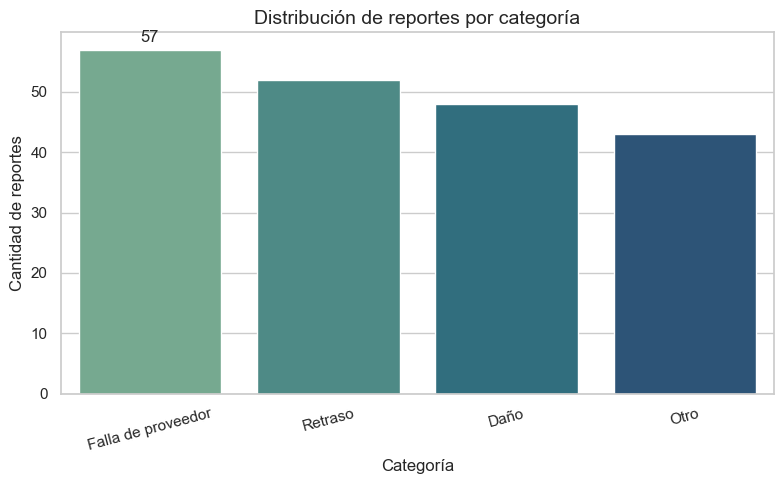

In [4]:
# Contar registros por categoría
conteo = data["categoria"].value_counts().reset_index()
conteo.columns = ["categoria", "cantidad"]

# Estilo visual
sns.set(style="whitegrid")

# Crear gráfica
plt.figure(figsize=(8,5))
ax = sns.barplot(x="categoria", y="cantidad", data=conteo, palette="crest")

# Personalizar
plt.title("Distribución de reportes por categoría", fontsize=14)
plt.xlabel("Categoría", fontsize=12)
plt.ylabel("Cantidad de reportes", fontsize=12)
plt.xticks(rotation=15)
plt.bar_label(ax.containers[0], fmt="%d", padding=3)

# Mostrar
plt.tight_layout()
plt.show()

### Función `limpiar_texto()`

Esta función realiza el **preprocesamiento básico del texto** antes de aplicar modelos de NLP.  
Su objetivo es estandarizar los reportes logísticos eliminando ruido y dejando solo las palabras relevantes.

**Pasos que realiza:**
1. Convierte todo el texto a minúsculas.  
2. Elimina tildes y caracteres especiales.  
3. Quita signos de puntuación y números.  
4. Elimina *stopwords* en español (palabras sin valor semántico).  
5. Une nuevamente los tokens limpios en una cadena lista para vectorización.


In [5]:
def limpiar_texto(texto):
    # 1. Minusculas
    texto = texto.lower()
    # 2. Eliminar tildes
    texto = unidecode(texto)
    # 3. Eliminar signos de puntuacion y numeros
    texto = re.sub(r'[^a-zñáéíóú\s]', '', texto)
    # 4. Eliminar stopwords
    tokens = [palabra for palabra in texto.split() if palabra not in stop_words]
    # 5. Reunir texto limpio
    return " ".join(tokens)


### `FunctionTransformer`: integración de funciones personalizadas en el pipeline

El objeto `FunctionTransformer` de **scikit-learn** permite incluir **funciones personalizadas** dentro de un `Pipeline`, haciendo que el preprocesamiento forme parte del flujo completo de entrenamiento y predicción del modelo.

En este caso, se utiliza para aplicar la función `limpiar_texto()` sobre cada texto del dataset, garantizando que la limpieza ocurra de manera automática cada vez que el pipeline procese nuevos datos.

#### ¿Cómo funciona?

- `FunctionTransformer` actúa como un **conector entre funciones de Python y scikit-learn**.  
- Recibe una función que transforma los datos antes de pasarlos al siguiente paso del pipeline.  
- El parámetro `validate=False` permite procesar listas o series de texto directamente, sin convertirlas a arreglos NumPy.


In [7]:
# Definir una función explícita (en lugar de lambda)
def aplicar_limpieza(textos):
    return [limpiar_texto(t) for t in textos]

# Crear el transformador con la función nombrada
cleaner = FunctionTransformer(aplicar_limpieza, validate=False)

###  `Pipeline`: encadenar etapas del proceso de NLP

Un **`Pipeline`** en *scikit-learn* permite **encadenar varios pasos de procesamiento y modelado** en una sola estructura coherente.  
Su propósito es simplificar el flujo de trabajo de *Machine Learning*, asegurando que todas las transformaciones y el entrenamiento del modelo se realicen en el **orden correcto** y de forma reproducible.

####  ¿Cómo funciona un pipeline?

Un pipeline ejecuta secuencialmente una serie de pasos definidos como tuplas `(nombre, objeto)`.  
Cada paso recibe la salida del anterior, y al final se obtiene un modelo completo que puede entrenarse (`fit`) y usarse para predecir (`predict`).

En este caso, el pipeline de NLP tiene tres etapas:

```python
modelo_nlp = Pipeline([
    ("cleaner", cleaner),            # 1️⃣ Limpieza de texto (FunctionTransformer)
    ("tfidf", TfidfVectorizer()),    # 2️⃣ Conversión de texto a vectores numéricos (TF-IDF)
    ("clf", MultinomialNB())         # 3️⃣ Clasificación con Naive Bayes
])


In [8]:
# Crear el pipeline completo
modelo_nlp = Pipeline([
    ("cleaner", cleaner),
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

Se divide el dataset en conjuntos de **entrenamiento (70%)** y **prueba (30%)** para evaluar el rendimiento del modelo de NLP de forma controlada.


In [9]:
# Entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    data["reporte"], data["categoria"], test_size=0.3, random_state=42
)

Se entrena el pipeline completo con los datos de entrenamiento y se evalúa su desempeño en el conjunto de prueba mediante métricas de clasificación. 

In [10]:
# Entrenar
modelo_nlp.fit(X_train, y_train)

# Evaluar
y_pred = modelo_nlp.predict(X_test)
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

              Daño       1.00      1.00      1.00        17
Falla de proveedor       1.00      1.00      1.00        11
              Otro       1.00      1.00      1.00        17
           Retraso       1.00      1.00      1.00        15

          accuracy                           1.00        60
         macro avg       1.00      1.00      1.00        60
      weighted avg       1.00      1.00      1.00        60



Se prueban nuevos reportes logísticos para que el modelo prediga automáticamente la categoría correspondiente a cada caso. 


In [11]:
nuevos = [
    "El pedido llegó con varias cajas dañadas",
    "El proveedor no cumplió con el envío",
    "Demora por congestión en el puerto",
    "Error en la documentación de transporte",
    "El camion de reparto se quedo sin gasolina y no pudo llegar a su destino"
]

pred = modelo_nlp.predict(nuevos)
for r, c in zip(nuevos, pred):
    print(f"📝 {r} → 📦 {c}")

📝 El pedido llegó con varias cajas dañadas → 📦 Daño
📝 El proveedor no cumplió con el envío → 📦 Falla de proveedor
📝 Demora por congestión en el puerto → 📦 Retraso
📝 Error en la documentación de transporte → 📦 Otro
📝 El camion de reparto se quedo sin gasolina y no pudo llegar a su destino → 📦 Retraso


Se guarda el pipeline completo (`modelo_nlp_pipeline.pkl`), que incluye tanto el modelo de **vectorización TF-IDF** como el modelo de **clasificación Naive Bayes** y el paso de **limpieza de texto**.  
De esta forma, el flujo de preprocesamiento y predicción puede reutilizarse sin necesidad de volver a entrenar el modelo.


In [12]:
import joblib

# Guardar el pipeline entrenado en un archivo .pkl
joblib.dump(modelo_nlp, "modelo_nlp_pipeline.pkl")

print("✅ Pipeline guardado correctamente en 'modelo_nlp_pipeline.pkl'")


✅ Pipeline guardado correctamente en 'modelo_nlp_pipeline.pkl'


In [13]:
# Cargar el pipeline entrenado desde el archivo
modelo_cargado = joblib.load("modelo_nlp_pipeline.pkl")

In [14]:
# Pedir al usuario un texto para clasificar
texto_usuario = input("✍️ Ingresa un reporte logístico: ")

# Realizar la predicción
prediccion = modelo_cargado.predict([texto_usuario])[0]

# Mostrar el resultado
print(f"📝 Reporte: {texto_usuario}")
print(f"📦 Categoría predicha: {prediccion}")


📝 Reporte: Durante el transporte se dañaron los porductos cargados
📦 Categoría predicha: Daño
